<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/355_mcmc_diagnostics.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(diagnostics_mcmc_notebook)=
# Diagnostica delle catene markoviane

Data la complessità computazionale intrinseca negli algoritmi MCMC (Markov Chain Monte Carlo), l'analisi della convergenza assume un ruolo cruciale nell'inferenza bayesiana. Il concetto di convergenza nell'MCMC è particolare: l'algoritmo è progettato per convergere verso una distribuzione, e non verso una singola stima puntuale. Questa specificità solleva l'esigenza di un'analisi diagnostica multidimensionale per valutare la qualità della convergenza.

Le catene di Markov sono utilizzate per approssimare la distribuzione a posteriori. Tuttavia, è fondamentale riconoscere che tale approssimazione è soggetta a errori e imperfezioni. Di conseguenza, emergono questioni cruciali quali la dimensione ottimale del campione, l'efficienza del campionamento e l'integrità delle stime parametriche, tra le altre. 

La diagnostica delle catene Markoviane, quindi, si configura come un insieme di pratiche e strumenti mirati a indagare vari aspetti della convergenza. Questi includono l'accuratezza dell'approssimazione della distribuzione a posteriori, l'efficienza del campionamento e l'esplorazione esaustiva dello spazio dei parametri. Tali strumenti diagnostici possono essere sia grafici che numerici e dovrebbero essere applicati in un contesto olistico per fornire una panoramica completa della qualità della catena di Markov. 

Non esiste un'unica metrica o diagnostico che possa fornire un quadro completo; piuttosto, è l'analisi combinata di più metriche e diagnostici che permette di acquisire una comprensione più profonda del comportamento della catena. Inoltre, l'esperienza del ricercatore gioca un ruolo significativo nel distinguere tra una "buona" e una "cattiva" catena di Markov e nel suggerire strategie per migliorare la qualità del campionamento.

In sintesi, l'analisi della convergenza e la diagnostica delle catene Markoviane sono fasi imprescindibili nel processo di inferenza bayesiana, soprattutto quando si utilizzano metodi MCMC. La loro applicazione consente di garantire che le stime a posteriori siano tanto accurate e affidabili quanto possibile.

In [1]:
from scipy import stats
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Esame dei Grafici di Tracciamento

Un metodo diagnostico comunemente utilizzato per valutare la convergenza nei metodi di Monte Carlo basati su catene di Markov (MCMC) è l'analisi dei grafici di tracciamento, o "trace plots". Questi grafici rappresentano sequenzialmente le stime dei parametri posteriori ottenute ad ogni iterazione della catena. In generale, si tende a interpretare che un parametro sta convergendo quando le stime campionarie si aggregano in una banda orizzontale ristretta lungo l'asse delle iterazioni che compongono la catena. Tuttavia, considerare questa disposizione come prova conclusiva di convergenza è piuttosto grossolano, in quanto una traccia compatta non garantisce che la convergenza sia stata effettivamente raggiunta. Di fatto, questa metodologia risulta essere più un indicatore di non-convergenza. Ad esempio, se due catene per lo stesso parametro sono campionate da regioni diverse della distribuzione target e le stime rimangono separate lungo la storia della catena, ciò costituisce un'evidenza di non-convergenza. Allo stesso modo, se il grafico mostra fluttuazioni significative o salti nella catena, è probabile che la catena associata a quel parametro non abbia raggiunto la convergenza.

Un trace plot ideale presenta una dispersione casuale dei valori attorno a un livello medio stabile, indicando una buona miscelazione delle catene e un'adeguata configurazione del processo MCMC. Questo pattern suggerisce che l'algoritmo è assestato su una distribuzione stabile e le inferenze tratte dai dati campionati sono affidabili.

Approfondendo con l'esempio di {cite:t}`martin2022bayesian`, è possibile osservare diversi esempi di trace plots per catene MCMC. Questi esempi illustrano sia scenari in cui il comportamento è ottimale, segnalando una convergenza adeguata, sia casi in cui le catene mostrano segni di problemi di convergenza o di miscelazione. Tali situazioni indicano la necessità di un'ulteriore affinazione dei parametri dell'algoritmo MCMC per garantire l'affidabilità delle stime statistiche ottenute.

In [3]:
good_chains = stats.beta.rvs(2, 5, size=(2, 2000))
bad_chains0 = np.random.normal(
    np.sort(good_chains, axis=None), 0.05, size=4000
).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i % 2 :, i : i + 100] = np.random.beta(i, 950, size=100)

chains = {
    "good_chains": good_chains,
    "bad_chains0": bad_chains0,
    "bad_chains1": bad_chains1,
}

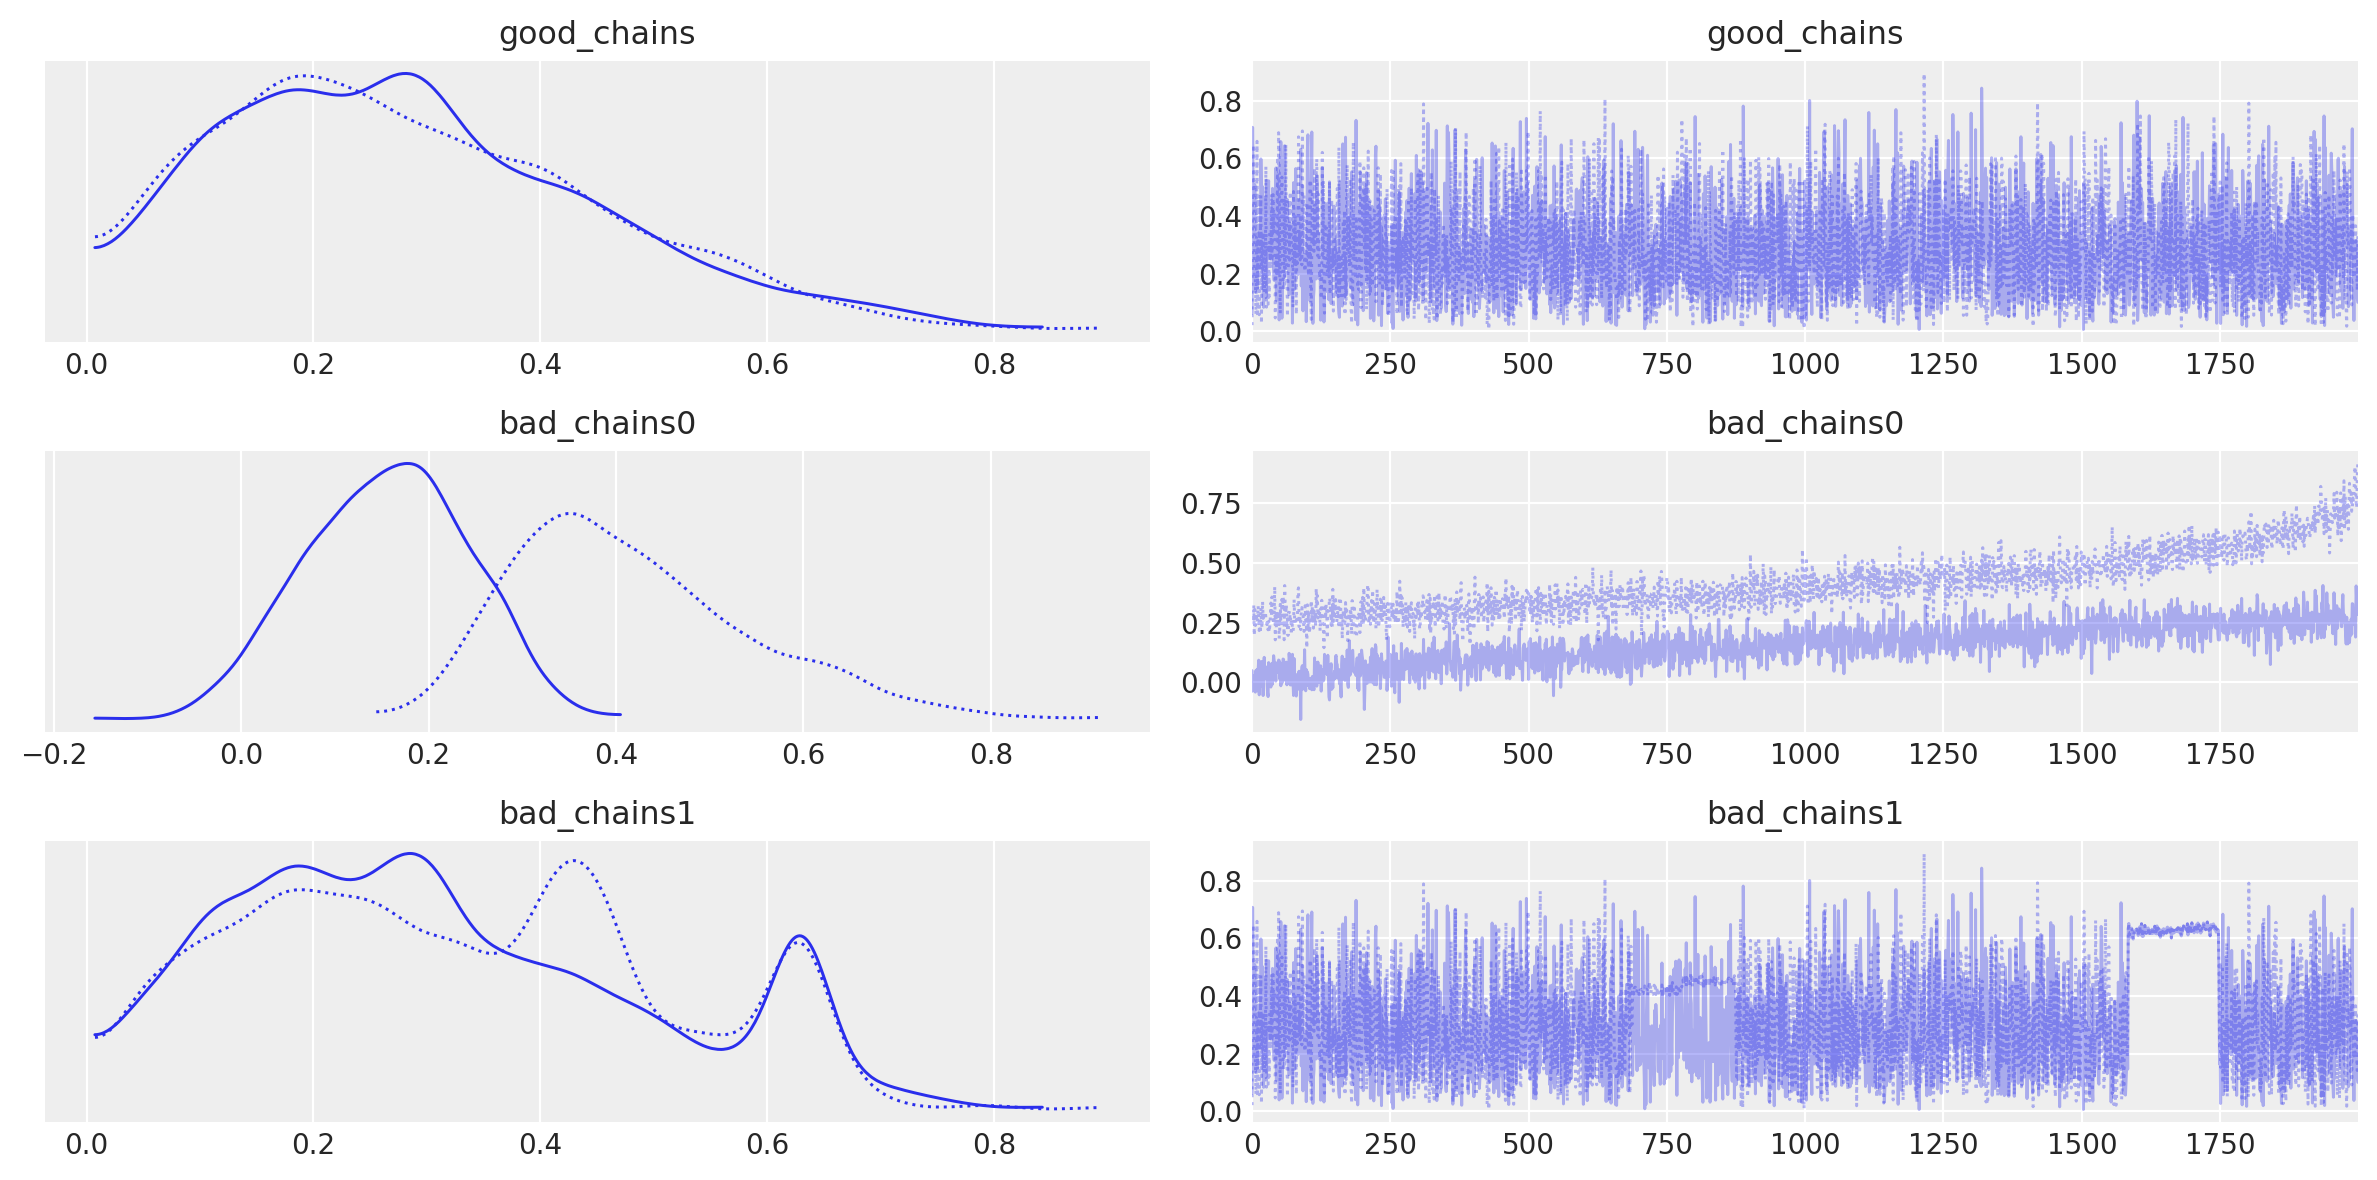

In [4]:
_ = az.plot_trace(chains)
plt.tight_layout()

Le cattive catene non convergono né si mescolano tra loro. Uno dei motivi per l'esecuzione di più catene è che ogni singola catena potrebbe convergere verso un target, mentre un'altra catena potrebbe convergere su un target diverso, e questo sarebbe un problema. Inoltre, catene altrimenti sane possono bloccarsi occasionalmente nel corso della serie, il che suggerirebbe la necessità di modifiche al modello o alle impostazioni del campionatore. Un altro modo per valutare la convergenza dell'algoritmo è plottando la densità della distribuzione a posteriori degli effetti stimati, per assicurarsi che si avvicini ad una classica curva a campana. 

In pratica, non abbiamo mai il privilegio di poter confrontare i risultati del campionamento MCMC con la corretta distribuzione a posteriori. Ecco perché la diagnostica delle catene di Markov è così importante: se vediamo trace-plots come le precedenti "bad chains", sappiamo che non abbiamo ottenuto una approssimazione adeguata della distribuzione a posteriori. In tali circostanze possiamo ricorrere ad alcuni rimedi.

1.  Controllare il modello. Siamo sicuri che le distribuzioni a priori e la verosimiglianza siano appropriate per i dati osservati?
2.  Utilizzare un numero maggiore di iterazioni. Alcune tendenze indesiderate a breve termine della catena possono appianarsi nel lungo termine.

## Analisi dei Grafici della Densità Posteriore

I grafici della densità posteriore rappresentano uno degli strumenti diagnostici più efficaci per identificare eventuali anomalie nella convergenza delle catene di Markov nell'analisi bayesiana. Questi grafici mostrano la distribuzione dei valori campionati per ogni parametro del modello statistico e per ogni catena di Markov. L'importanza di questi grafici è primaria: essi sono la base da cui deriviamo le statistiche riassuntive dei parametri del modello, quali la media, la mediana, o l'intervallo di credibilità.

Prendiamo come esempio un parametro di interesse in un modello di regressione che assume una distribuzione a priori gaussiana (normale). In un contesto ideale, senza problemi di convergenza, ci aspetteremmo che la densità posteriore del parametro sia anch'essa normalmente distribuita, centrata intorno a una media con una certa varianza. Questo andamento simmetrico e unimodale della densità posteriore è un segnale che la catena di Markov ha esplorato adeguatamente lo spazio dei parametri e che i campioni estratti possono essere considerati rappresentativi della distribuzione posteriore effettiva del parametro.

Tuttavia, se il grafico della densità posteriore mostra deviazioni significative dalla forma attesa, come ad esempio asimmetrie marcate o bimodalità, questo suggerisce che potrebbero esserci problemi nella convergenza della catena al vero valore del parametro. Una distribuzione bimodale, in particolare, può indicare che la catena è rimasta "intrappolata" in aree locali dello spazio dei parametri, senza riuscire a esplorare adeguatamente l'intero spazio e raggiungere l'equilibrio.

Per risolvere tali problemi e ottenere una stima più accurata della distribuzione posteriore, potremmo considerare diverse strategie:

1. **Aumentare il Numero di Iterazioni**: Incrementare il numero delle iterazioni delle catene di Markov può permettere una migliore esplorazione dello spazio dei parametri e aiutare a superare le barriere tra i picchi di una distribuzione bimodale.

2. **Ottimizzazione delle Distribuzioni a Priori**: La scelta delle distribuzioni a priori può influenzare fortemente la convergenza della catena. Selezionare priori più informativi o più flessibili può aiutare la catena a guidare l'esplorazione dello spazio dei parametri in modo più efficace.

3. **Affinamento dei Parametri dell'Algoritmo MCMC**: Modificare i parametri di configurazione dell'algoritmo MCMC, come il passo del campionamento o i criteri di accettazione, può migliorare la qualità del campionamento e favorire una convergenza più rapida e stabile.

In definitiva, l'analisi dei grafici della densità posteriore non solo fornisce una stima visiva dell'andamento dei parametri, ma serve anche come fondamento per decisioni metodologiche che possono migliorare la robustezza e l'affidabilità delle inferenze bayesiane.

## Analisi dell'Autocorrelazione nelle Catene di Markov Monte Carlo

Nell'ambito dell'analisi bayesiana tramite le catene di Markov Monte Carlo (MCMC), è di fondamentale importanza valutare la rapidità con cui i campioni estratti dalla distribuzione a posteriori raggiungono l'indipendenza. Inizialmente, come è noto, i campioni della distribuzione a posteriori non sono indipendenti l'uno dall'altro, ma ci si aspetta che, nel tempo, la catena "dimentichi" il suo stato iniziale e converga verso un insieme di estrazioni indipendenti e stazionarie dalla distribuzione a posteriori.

Una metodologia per determinare la velocità con cui la catena si allontana dallo stato iniziale è l'analisi della funzione di autocorrelazione (ACF), che si basa sull'osservazione che un campione $\theta^{(s)}$ tende a essere più simile al campione immediatamente precedente $\theta^{(s-1)}$ rispetto a quelli più distanti come $\theta^{(s-2)}$, $\theta^{(s-3)}$, e così via. La correlazione di lag-l per una catena stazionaria di Markov, dove $ s = 1, \ldots, S $, può essere espressa come:

$$
\rho_l = \text{cor}(\theta^{(s)}, \theta^{(s+l)}).
$$

In generale, ci aspettiamo che l'autocorrelazione a lag-1 sia vicina a 1, ma che diminuisca man mano che il lag aumenta, indicando che i componenti della catena stanno diventando indipendenti. Una riduzione rapida dell'autocorrelazione con il numero di iterazioni è preferibile, poiché una lenta diminuzione può suggerire che la catena sia "intrappolata" e non esplori completamente il supporto della distribuzione target.

Il correlogramma, che mostra l'autocorrelazione in funzione dei ritardi fino a un certo valore (ad esempio 20), è utile per valutare questa caratteristica. Se l'autocorrelazione a lag 1 non è eccessivamente alta e diminuisce rapidamente con l'incremento dei lag, ciò indica che la catena sta fornendo una buona approssimazione di un campionamento casuale dalla distribuzione $ p(\theta \mid y) $.

Catene che mostrano un rapido "mixing" si comportano in modo simile a un campione indipendente: i valori si concentrano nei range più plausibili della distribuzione a posteriori e l'autocorrelazione tra i campioni diminuisce rapidamente, risultando in un rapporto campionario effettivo alto. Al contrario, catene che non sono rapidamente "mixing" tendono a non concentrarsi nei valori più plausibili, presentano un'autocorrelazione che diminuisce lentamente e un rapporto campionario effettivo basso.

In caso di catene non rapidamente "mixing", si possono adottare due strategie:

1. **Aumento del Numero di Iterazioni**: Anche una catena lenta nel "mixing" può alla fine fornire una buona approssimazione della distribuzione a posteriori se si permette un numero sufficientemente grande di iterazioni.

2. **Thinning (Diradamento)**: Questo processo consiste nel selezionare solo alcuni campioni a intervalli regolari, come ogni secondo o ogni decimo valore della catena, con l'obiettivo di ridurre le autocorrelazioni presenti nei lag più brevi.

Un esempio pratico è fornito da {cite:p}`martin2022bayesian`.

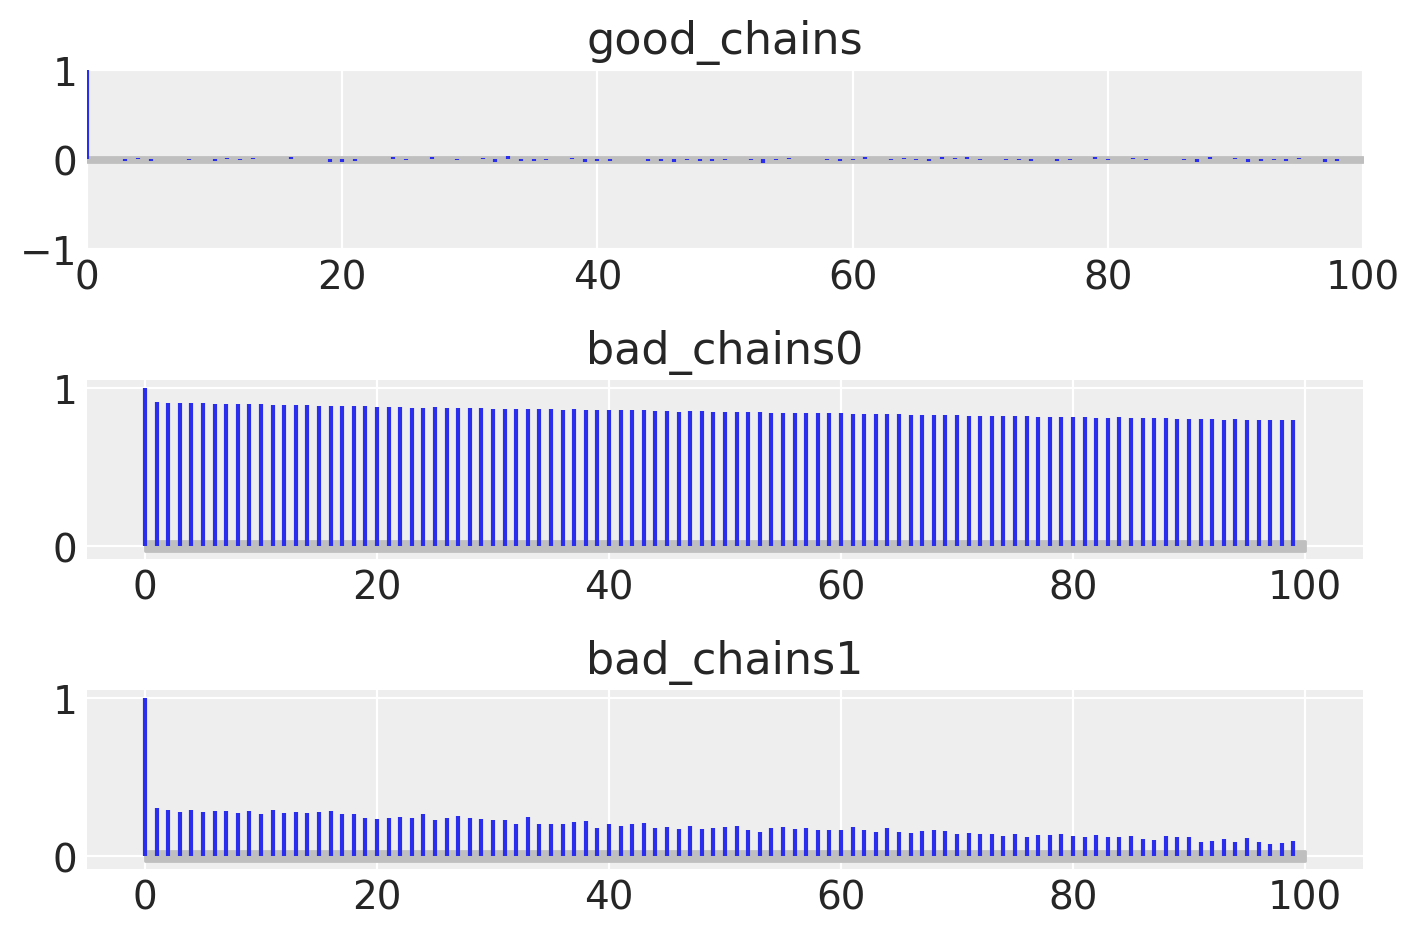

In [5]:
fig, ax = plt.subplots(3, 1)  
az.plot_autocorr(chains, combined=True, ax=ax)
plt.tight_layout()

## Dimensione Effettiva del Campione nelle Analisi MCMC

Nell'ambito delle analisi con catene di Markov Monte Carlo (MCMC), un aspetto strettamente correlato alla diagnosi di autocorrelazione è la dimensione effettiva del campione, indicata con $ N_{\text{eff}} $ nell'output del software Stan. Questa grandezza rappresenta una stima del numero di estrazioni indipendenti dalla distribuzione a posteriori. In altre parole, corrisponde al numero di campioni indipendenti che possiede lo stesso potere di stima di $ T $ campioni autocorrelati. Seguendo la notazione di Stan, la $ N_{\text{eff}} $ è calcolata come segue:

$$
N_{\text{eff}} = \frac{T}{1 + 2 \sum_{s=1}^{S} \rho_{s}},
$$

dove $ T $ è il numero totale di campioni e $ \rho_{s} $ rappresenta l'autocorrelazione a lag $ s $.

Poiché i campioni della distribuzione a posteriori non sono indipendenti, ci aspettiamo che la $ N_{\text{eff}} $ sia minore del numero totale di estrazioni. Se il rapporto tra la dimensione effettiva del campione e il numero totale di estrazioni è vicino a 1, ciò indica che l'algoritmo ha raggiunto un campionamento sostanzialmente indipendente. Valori molto inferiori potrebbero essere motivo di preoccupazione poiché indicano una forte dipendenza tra i campioni, ma è importante notare che questo rapporto dipende fortemente dalla scelta dell'algoritmo MCMC, dal numero di iterazioni di "warmup" (o "burn-in"), e dal numero di iterazioni successive al "warmup".

Un metodo per affrontare il problema dell'autocorrelazione e del conseguente abbassamento della dimensione effettiva del campione coinvolge l'uso del diradamento (*thinning*). Supponiamo che l'algoritmo venga impostato per effettuare 3.000 estrazioni dalla distribuzione a posteriori. Questo può essere paragonato a effettuare 30.000 estrazioni ma conservando solo ogni decima. Sebbene questo metodo sia un modo per ridurre il carico sulla memoria, il vantaggio è che tipicamente l'autocorrelazione viene ridotta, risultando in una dimensione effettiva del campione maggiore.

Per distinguere tra buone e cattive catene MCMC, possiamo utilizzare la statistica $ N_{\text{eff}} $. Un basso valore di $ N_{\text{eff}} $ può indicare una catena con una mescolanza insufficiente, suggerendo la necessità di aumentare il numero di iterazioni o di implementare il diradamento. In contrasto, un valore alto di $ N_{\text{eff}} $ è indice di una catena con una buona mescolanza, che assicura un campionamento efficace dalla distribuzione a posteriori. Esempi pratici di queste considerazioni sono illustrati in {cite:t}`martin2022bayesian`, dove la statistica $ N_{\text{eff}} $ è utilizzata per valutare la qualità delle catene MCMC.

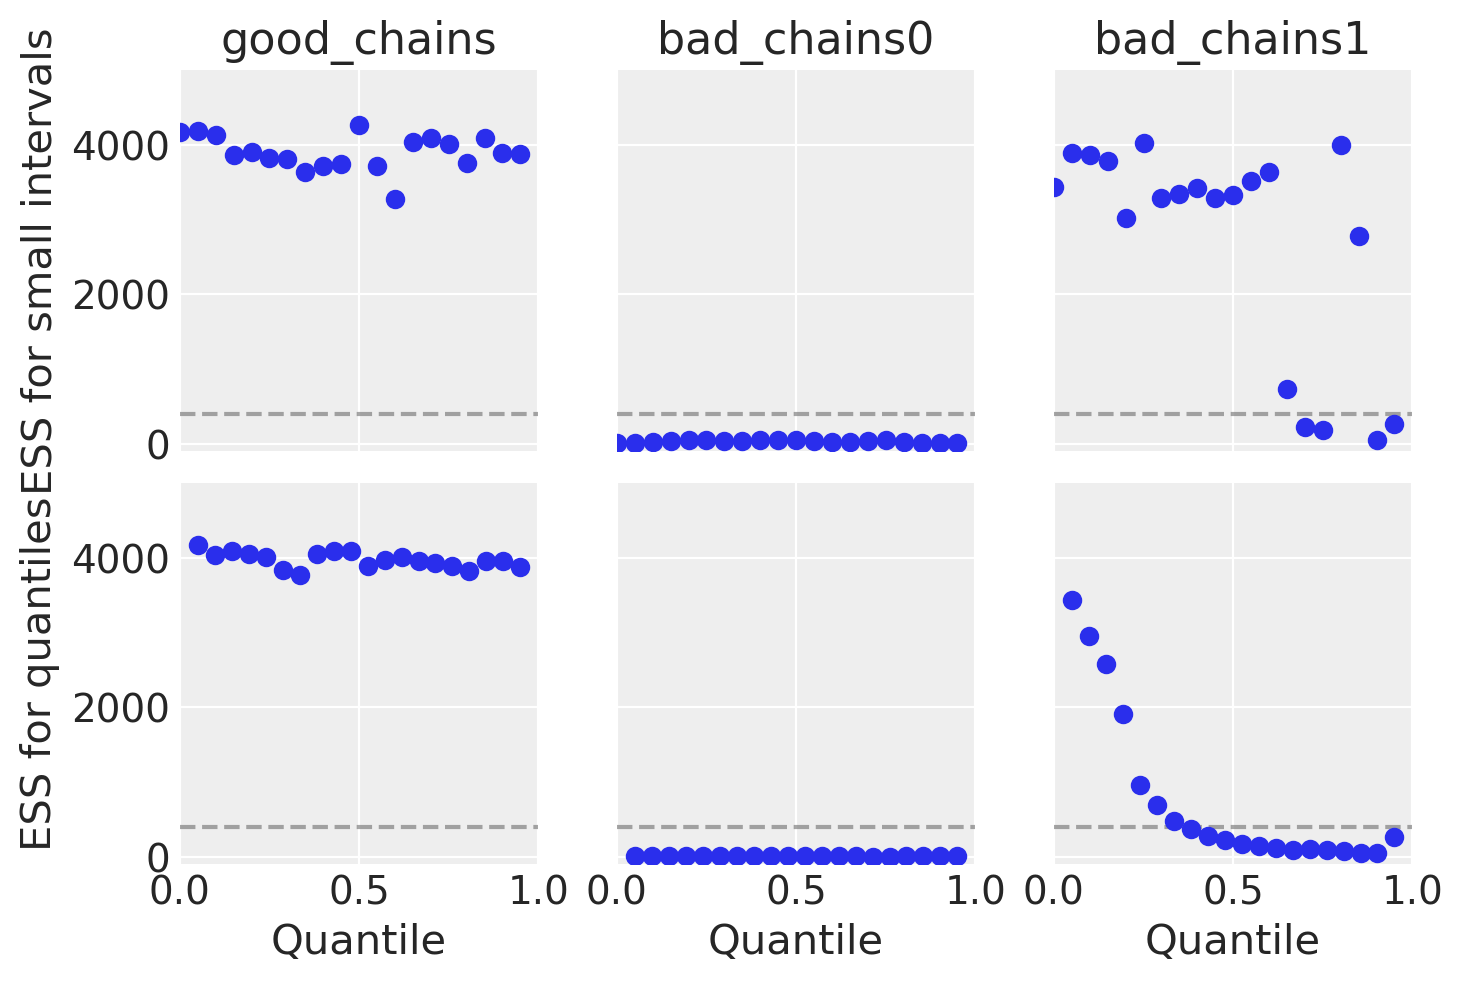

In [6]:
_, axes = plt.subplots(2, 3, sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])

for ax_ in axes[0]:
    ax_.set_xlabel("")
for ax_ in axes[1]:
    ax_.set_title("")

for ax_ in axes[:, 1:].ravel():
    ax_.set_ylabel("")
plt.ylim(-100, 5000);

## Statistica $\hat{R}$

Nell'ambito dell'analisi bayesiana, è cruciale assicurarsi che ogni catena di Markov sia stazionaria e che le diverse catene mostrino coerenza tra loro. La statistica $\hat{R}$, introdotta da Gelman e Rubin nel 1992, serve proprio a valutare il grado di convergenza tra più catene per ciascun parametro in esame. Questo indicatore si basa sul confronto tra due tipi di varianza: la varianza media all'interno di ogni singola catena (W) e la varianza tra le diverse catene (B). Questo metodo ricorda l'approccio dell'analisi della varianza unidirezionale, in cui si confrontano stime di varianza per determinare se esistono differenze significative, in questo caso tra le catene.

La formula per calcolare $\hat{R}$ è $\hat{R} = \frac{W + \frac{1}{n} (B - W)}{W}$, e tale metrica viene calcolata automaticamente dalla maggior parte dei software Bayesiani, come indicato da Gelman e collaboratori nel 2014. Nel contesto pratico, un valore di $\hat{R}$ superiore a 1.1 è generalmente considerato un segnale di convergenza inadeguata delle catene. Inoltre, è fondamentale esaminare visivamente la convergenza delle catene attraverso il confronto delle distribuzioni posteriori di ciascun parametro per ogni catena. In condizioni ideali, $\hat{R}$ dovrebbe essere pari a 1. Se $\hat{R}$ si discosta notevolmente da questo valore, ciò indica che la convergenza non è stata ancora raggiunta.

Più specificamente, un valore di $\hat{R}$ maggiore di 1.01, secondo {cite:p}`vehtari2021rank`, segnala una mancanza di coerenza nelle approssimazioni della distribuzione a posteriori ottenute dalle diverse catene parallele. Un valore così elevato di $\hat{R}$ suggerisce una simulazione non stabile, indicando la necessità di ulteriori iterazioni o di un raffinamento del modello per garantire una convergenza affidabile. Questo aspetto è fondamentale per assicurare che le simulazioni Monte Carlo basate su catene di Markov (MCMC) forniscano risultati consistenti e attendibili per l'analisi statistica in corso.

In [7]:
az.rhat(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 1.0
    bad_chains0  float64 2.424
    bad_chains1  float64 1.015

Nell'esempio di {cite:t}`martin2022bayesian` vediamo come $\hat{R}$ è in grado di distinguere tra le buone e le cattive catene MCMC. Mentre `bad_chains0` ha valori $\hat{R}$ totalmente inadeguati, `bad_chains1` tende ad avere valori accettabili e `good_chains` ha un valore $\hat{R}$ praticamente uguale a 1.0.

## Diagnostica di convergenza di Geweke

La statistica diagnostica di convergenza di Geweke è basata su un test per l'uguaglianza delle medie della prima e dell'ultima parte di una catena di Markov (di default il primo 10% e l'ultimo 50% della catena). Se i due campioni sono estratti dalla distribuzione stazionaria della catena, le due medie sono statisticamente uguali e la statistica di Geweke ha una distribuzione asintotica Normale standardizzata.

**Interpretazione:** la statistica di Geweke è uguale a zero quando le medie delle due porzioni della catena di Markov sono uguali; valori maggiori di $\mid 2 \mid$ suggeriscono che la catena non ha ancora raggiunto una distribuzione stazionaria.


## Errore standard di Monte Carlo

Quando utilizziamo i metodi MCMC introduciamo un ulteriore livello di incertezza poiché stiamo approssimando il posteriore con un numero finito di campioni. Possiamo stimare la quantità di questo tipo di errore mediante la statistica *errore standard di Monte Carlo* (MCSE). Il MCSE è definitp come la deviazione standard delle catene MCMC divisa per la loro numerosità campionaria effettiva (ESS). Il MCSE ci fornisce dunque un'indicazione quantitativa di quanto è grande sia il "rumore" della stima.

Per l'esempio di {cite:t}`martin2022bayesian` otteniamo i valori seguenti.

In [8]:
az.mcse(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.002553
    bad_chains0  float64 0.1097
    bad_chains1  float64 0.01815

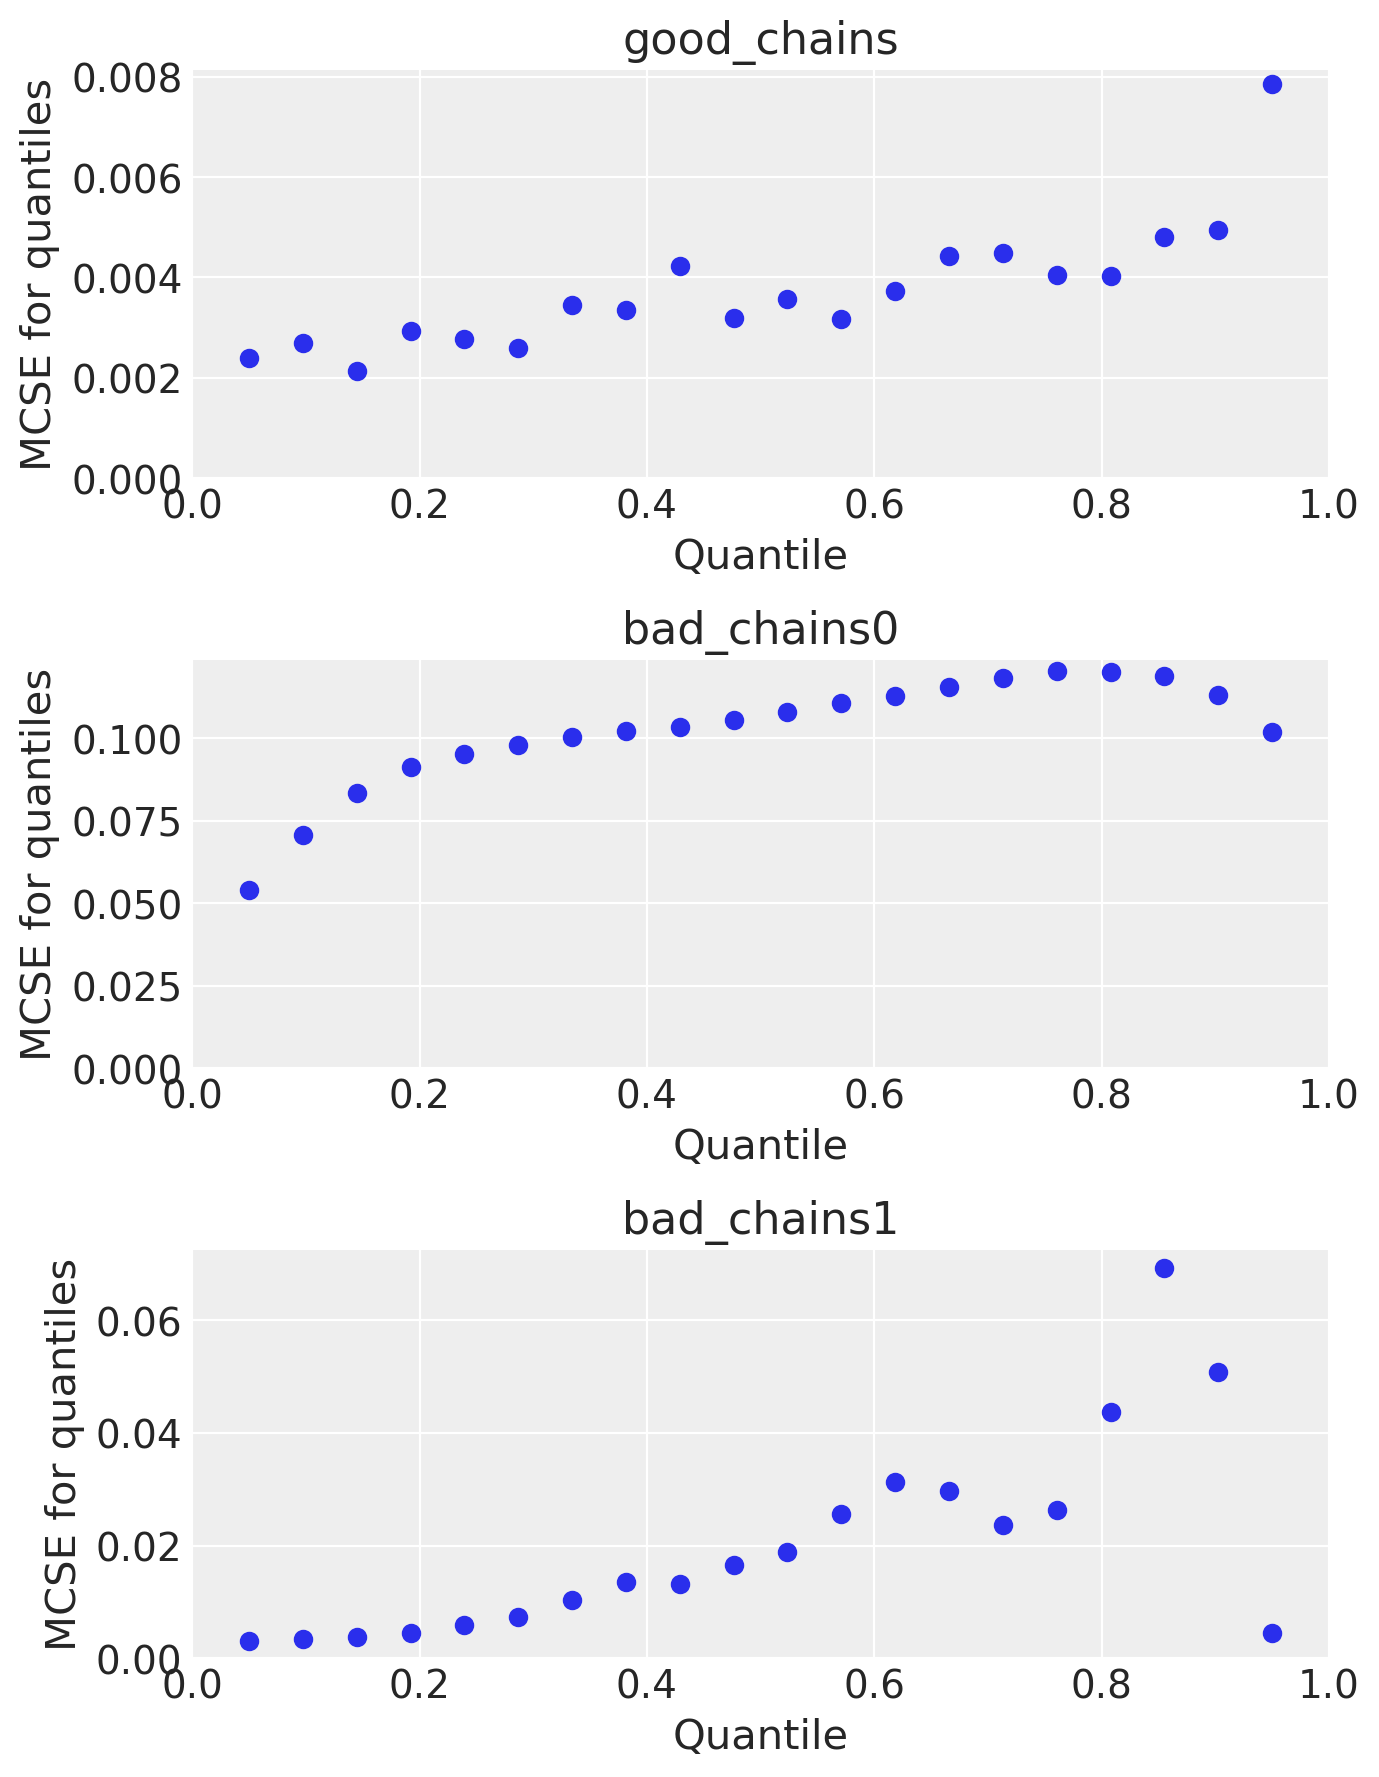

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(7, 9))  
az.plot_mcse(chains, ax=ax)
plt.tight_layout()

## Grafici di rango

In alcune situazioni, l'interpretazione dei grafici di traccia può risultare estremamente complessa. Ad esempio, quando si raccolgono un numero molto elevato di campioni, comprimere lunghe tracce in un grafico di dimensioni standard può occultare alcuni comportamenti problematici delle catene, facendo apparire erroneamente buone le tracce. Giudicare i grafici di traccia può essere difficile anche quando le distribuzioni sono fortemente asimmetriche e/o a code pesanti. Per queste ragioni, ora si raccomanda di utilizzare i grafici di rango oltre, se non al posto, dei grafici di traccia, in modo che qualsiasi differenza nei valori campionati da ogni catena possa essere riconosciuta in un modo più affidabile (Vehtari et al., 2021). 

In statistica, il “rango” di un’osservazione è la sua posizione in un insieme di dati ordinati. Ad esempio, consideriamo il seguente insieme di dati: [5, 3, 8, 10]. Se ordiniamo questi dati in ordine crescente otterremo [3, 5, 8, 10]. In questo caso, il rango del numero 5 è 2 perché è il secondo numero nell’insieme ordinato. Allo stesso modo, il rango del numero 10 è 4 perché è il quarto numero nell’insieme ordinato.

I grafici di rango rappresentano un nuovo strumento diagnostico che si ottiene ordinando i campioni aggregati da tutte le catene, e poi presentando un istogramma dei ranghi derivanti da ogni catena separatamente. Se tutte le catene hanno come target la stessa distribuzione, allora la distribuzione dei ranghi per ogni catena dovrebbe approssimare una distribuzione uniforme. Inoltre, se i grafici dei ranghi di tutte le catene sembrano simili, ciò indica una buon mixing delle catene. Le deviazioni dall'uniformità possono indicare una vasta gamma di problemi di convergenza. Qui sotto è riportato l'esempio fornito da {cite:t}`martin2022bayesian`:

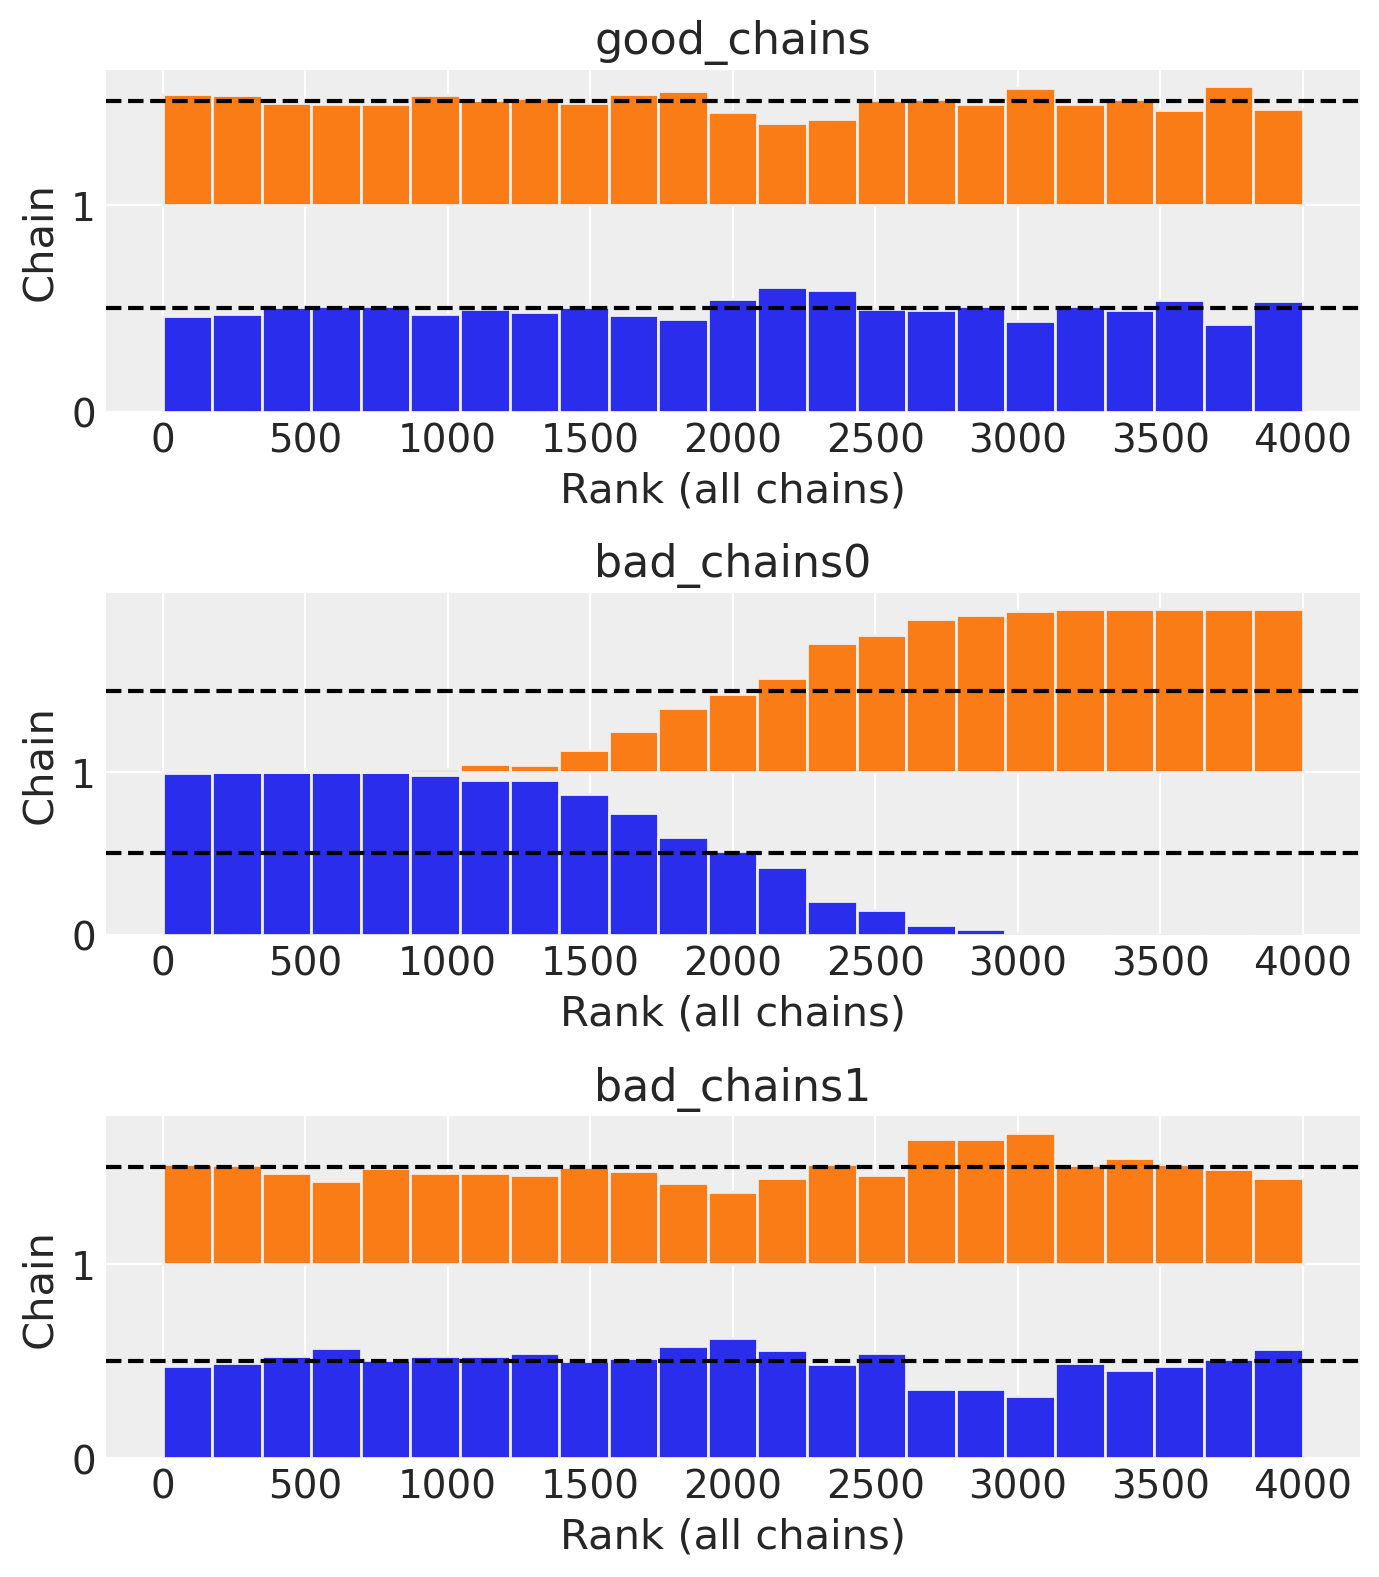

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(7, 8))  
az.plot_rank(chains, kind="bars", ax=ax)
plt.tight_layout()

Una rappresentazione alternativa (con dei segmenti verticali al posto delle barre) è la seguente:

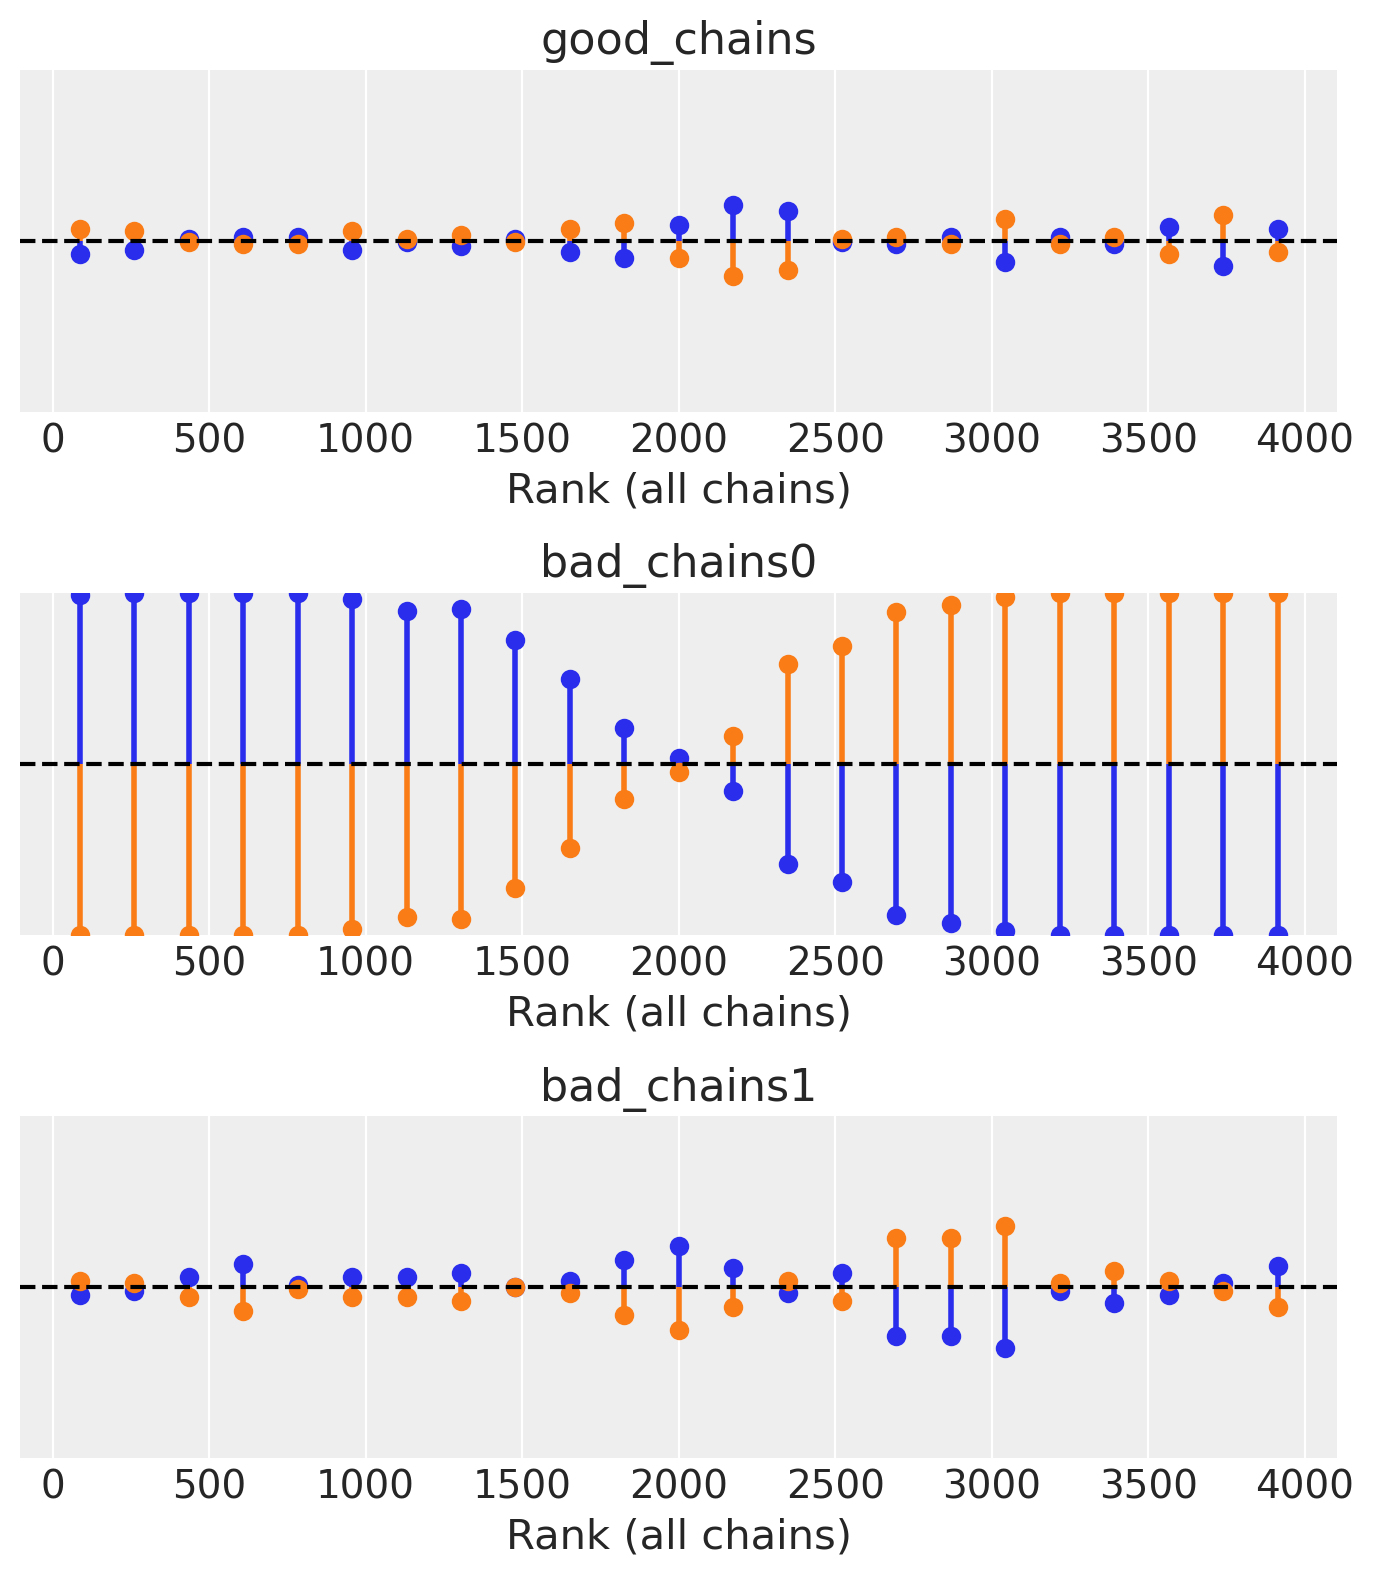

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(7, 8))  
az.plot_rank(chains, kind="vlines", ax=ax)
plt.tight_layout()

## Transizioni Divergenti

Durante il processo di diagnosi del funzionamento di un campionatore, abbiamo finora focalizzato la nostra attenzione sull'analisi dei campioni generati. Una strategia diagnostica complementare consiste nel monitorare il comportamento dei meccanismi interni del metodo di campionamento. Un elemento chiave in questa analisi è il fenomeno delle *divergenze*, una caratteristica intrinseca di alcuni metodi Hamiltoniani Monte Carlo (HMC).

Le iterazioni divergenti si manifestano quando una catena tenta di raggiungere un determinato punto nella distribuzione congiunta a posteriori, ma non riesce a farlo a causa dell'elevata curvatura presente in quella regione dello spazio dei parametri. Queste divergenze svolgono un ruolo cruciale nella diagnosi, segnalando una esplorazione incompleta di alcune aree della distribuzione a posteriori e, di conseguenza, portando a campioni a posteriori potenzialmente distorti.

Le divergenze costituiscono un indicatore diagnostico altamente sensibile e dovrebbero essere utilizzate in sinergia con gli altri strumenti diagnostici delineati nelle sezioni precedenti per garantire una valutazione comprensiva e accurata del modello. È importante sottolineare che, in presenza di divergenze, i campioni risultanti non possono essere considerati affidabili e, pertanto, non dovrebbero essere impiegati per la stima dei parametri, il confronto tra modelli o qualsiasi altra forma di inferenza statistica {cite:p}`gelman2020bayesian`.

Per illustrare più chiaramente il concetto di divergenza, facciamo riferimento a un modello presentato da {cite:t}`martin2022bayesian`. In questo contesto, l'obiettivo è stimare il parametro $ \theta_2 $, che segue una distribuzione uniforme nell'intervallo $ [-\theta_1, \theta_1] $, mentre $ \theta_1 $ è determinato da una distribuzione normale. La distribuzione di $ \theta_2 $ è quindi strettamente legata a $ \theta_1 $: per valori elevati di $ \theta_1 $, $ \theta_2 $ avrà una distribuzione uniforme che copre un intervallo ampio, mentre con $ \theta_1 $ prossimo allo zero, l'ampiezza dell'intervallo di distribuzione di $ \theta_2 $ si ridurrà significativamente.

Sono proposte tre varianti di questo modello. Senza addentrarci nei dettagli tecnici, è importante notare che la versione etichettata come "modello 0" è afflitta da significative incongruenze. Come evidenziato nel grafico che segue, le transizioni divergenti sono indicate in blu, mostrando un'alta incidenza di tali anomalie.

```{image} ../images/divergences_pair.png
:height: 300px
:align: center
```

Il modello 1 è molto migliorato rispetto al precedente e questo si nota osservando, nella figura, che c'è un piccolo numero di *divergent transitions*. Il modello 1bis, infine, è adeguato, in quanto non è presente alcuna *divergent transition*. Per una discussione tecnica delle divergenze, si veda, ad esempio, [Stan Reference Manual](https://mc-stan.org/docs/reference-manual/divergent-transitions.html).

### Gestione delle Transizioni Divergenti nell'Hamiltonian Monte Carlo

Quando si utilizza un algoritmo di campionamento Hamiltonian Monte Carlo (HMC), è fondamentale prestare attenzione al numero di transizioni divergenti riportate nell'output, il quale idealmente dovrebbe essere zero. Una "transizione divergente" è un segnale di avviso che indica potenziali problemi nella fase di esplorazione dell'algoritmo: specificatamente, denota situazioni in cui l'algoritmo non è riuscito a sondare correttamente alcune regioni dello spazio dei parametri.

Indipendentemente dal numero di transizioni divergenti, ogni segnalazione di divergenza richiede un'analisi approfondita. La presenza di transizioni divergenti suggerisce che il campionatore non ha esplorato adeguatamente determinate aree dello spazio dei parametri, il che potrebbe compromettere la validità dell'intero processo di inferenza.

Per diagnosticare e risolvere il problema delle transizioni divergenti, è possibile seguire diverse strade:

1. **Controllo dei dati**: Verificare la presenza di osservaziozi anomale o valori estremi nei dati che potrebbero influenzare negativamente l'algoritmo.

2. **Adeguatezza delle distribuzioni a priori**: Esaminare se le distribuzioni a priori scelte sono appropriate per il modello e i dati in esame. Distribuzioni a priori non congruenti possono condurre a problematiche nella fase di esplorazione dello spazio dei parametri.

3. **Dimensione del passo**: Analizzare e, se necessario, regolare la dimensione del passo (*step size*) dell'algoritmo HMC. Un passo troppo grande o troppo piccolo può causare instabilità e portare a transizioni divergenti.

Affrontare con cura questi problemi può migliorare l'efficacia del campionamento HMC e ridurre il rischio di transizioni divergenti. La risoluzione di questi problemi è cruciale per garantire che l'algoritmo di campionamento produca una rappresentazione accurata della distribuzione a posteriori e, di conseguenza, inferenze statistiche affidabili.

## Bayesian fraction of missing information

Un altro strumento diagnostico recentemente introdotto, specifico per il campionamento HMC/NUTS, è la *Fraction of Missing Information* stimata in modo bayesiano (BFMI o E-BFMI; {cite:p}`betancourt2016diagnosing`). Questo indicatore, calcolato a partire dalla diagnostica dell'energia registrata durante la generazione di ciascuna iterazione all'interno di ogni catena, misura l'accuratezza dell'algoritmo HMC/NUTS a un livello computazionale più profondo rispetto ad altre diagnostiche.

Un valore di BFMI estremamente basso per una data catena segnala un'esplorazione insufficiente della distribuzione a posteriori, rendendo i campioni ottenuti potenzialmente distorti. Attualmente, è richiesto che il BFMI sia maggiore o uguale a 0.2 per tutte le catene (Stan Development Team, 2022). Se il valore scende sotto 0.2 in una o più catene, l'output non dovrebbe essere utilizzato per inferenze, poiché le stime a posteriori saranno distorte {cite:p}`betancourt2016diagnosing`.

## Leave-One-Out Cross-Validation (LOO)

La Leave-One-Out Cross-Validation (LOO) rappresenta un metodo ampiamente impiegato nell'ambito dell'analisi bayesiana per valutare quanto adeguatamente un modello statistico si adatta ai dati osservati. La peculiarità della LOO è la sua capacità di stimare l'adattamento attraverso una valutazione che avviene in modo oggettivo, evitando sia il sovraadattamento (overfitting) sia il sottadattamento (underfitting) del modello.

La LOO funziona nel seguente modo nel contesto dell'analisi bayesiana: per ogni punto di dati, si adatta il modello considerando tutti gli altri punti tranne quello in questione. Si calcola quindi la previsione (verosimiglianza) per il punto escluso. Questo processo si ripete per ciascun punto nel dataset. Al termine, le previsioni del modello vengono confrontate con i dati effettivamente esclusi, fornendo un'indicazione di quanto bene il modello abbia previsto i dati tralasciati.

Un vantaggio fondamentale della LOO è la prevenzione del rischio di sovra-adattamento, dato che il modello viene valutato su dati non utilizzati durante il processo di adattamento. Nell'ambito dell'analisi bayesiana, la LOO spesso si associa al calcolo del logaritmo della verosimiglianza (log-likelihood) per ogni osservazione esclusa. Tali log-likelihood possono essere utilizzati per calcolare la quantità denominata LOOIC (Leave-One-Out Information Criterion), consentendo la comparazione di diversi modelli basata sulla loro capacità di adattarsi ai dati.

In sintesi, all'interno dell'analisi bayesiana, la LOO svolge un ruolo rilevante nell'avalutare le prestazioni e l'adattamento dei modelli, offrendo una valutazione imparziale delle loro capacità di previsione.

## Parametro $\hat \kappa$

Il parametro $ k $, noto anche come parametro di coda di Pareto, riveste un ruolo importante nell'ambito del campionamento MCMC. È utilizzato per valutare l'efficienza e la convergenza delle catene di campionamento, nonché per misurare la qualità del processo di campionamento di importanza, come nel caso del Pareto Smoothed Importance Sampling (PSIS).

L'Importance Sampling è una tecnica che consente di ridistribuire la densità del campionamento verso le regioni di maggiore interesse. Nella PSIS, i pesi originali vengono "lisciati" usando una distribuzione di Pareto, riducendo così la varianza dell'approssimazione. Questo può essere particolarmente utile quando alcuni pesi sono molto grandi, cioè quando ci sono campioni che hanno una probabilità molto più alta secondo $ p(x) $ rispetto a $ q(x) $.

Il parametro $ k $ quantifica la fiducia che si può riporre nelle pesate di importanza all'interno della catena di campionamento. Un valore di $ k $ prossimo a 0 indica una solida affidabilità delle pesate, mentre un valore superiore a 0.7 segnala possibili instabilità e scarsa affidabilità delle pesate di importanza. Un valore elevato di $ k $ può anche rivelare una cattiva mescolanza della catena, implicando che i campioni successivi risultano fortemente correlati con quelli precedenti. Tale situazione può condurre a una sottostima della varianza nella distribuzione a posteriori, influenzando negativamente la qualità delle inferenze.

In sintesi, il parametro $ k $ offre una misurazione quantitativa dell'efficacia del processo di campionamento, servendo come strumento diagnostico per la valutazione della qualità della catena di campionamento MCMC. Aiuta a individuare potenziali problemi nella convergenza della catena e a guidare le decisioni relative alla sua lunghezza, al periodo di burn-in e ad altri aspetti metodologici. Un valore di $ k $ che superi una certa soglia, come 0.7, dovrebbe essere interpretato come un campanello d'allarme che invita ad un'analisi più approfondita della catena e dei potenziali problemi ad essa associati. La conoscenza e il monitoraggio accurato di questo parametro sono quindi essenziali per garantire un campionamento affidabile e per prevenire conclusioni errate o fuorvianti nell'analisi bayesiana.

Per calcolare il parametro $\hat \kappa$, è possibile fare uso di ArviZ, uno strumento appositamente progettato per le analisi bayesiane avanzate.

## Watermark

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 14 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

matplotlib: 3.8.1
numpy     : 1.25.2
arviz     : 0.16.1
pymc      : 5.9.2
seaborn   : 0.13.0
scipy     : 1.11.3

Watermark: 2.4.3

